# SSY340 Project - Trajectory Estimation LSTM

### Fill in group number and member names:

In [1]:
NAME1 = "Bingcheng Chen" 
NAME2 = "Arvin Rokni"
GROUP = "Project groups 64"

## 1. Loading the data

In [2]:
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import os
import dataloader
import model_LSTM
import utils
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

## 2. Pre-processing

In [3]:
# defining model save location
save_location = "./LSTM_models"
# defining dataset locations
dataset_folder = "./trajectory-prediction-transformers/datasets"
dataset_name = "raw"
# setting validation size. if val_size = 0, split percentage is 80-20
val_size = 0
# length of sequence given to encoder
gt = 8
# length of sequence given to decoder
horizon = 12


train_dataset, _ = dataloader.create_dataset(dataset_folder, dataset_name, val_size,
                                             gt, horizon, delim="\t", train=True)
val_dataset, _ = dataloader.create_dataset(dataset_folder, dataset_name, val_size,
                                           gt, horizon, delim="\t", train=False)
# test_dataset, _ = dataloader.create_dataset(dataset_folder, dataset_name, val_size, \
#     gt, horizon, delim="\t", train=False, eval=True)

In [4]:
val_dataset[10]

{'src': tensor([[ 4.9693e+00,  8.3395e+00,  0.0000e+00,  0.0000e+00],
         [ 5.1330e+00,  8.3350e+00,  1.6374e-01, -4.5338e-03],
         [ 5.2968e+00,  8.3307e+00,  1.6374e-01, -4.2963e-03],
         [ 5.3915e+00,  8.3490e+00,  9.4709e-02,  1.8377e-02],
         [ 5.4565e+00,  8.3774e+00,  6.5034e-02,  2.8400e-02],
         [ 5.5218e+00,  8.4058e+00,  6.5244e-02,  2.8400e-02],
         [ 5.5868e+00,  8.4342e+00,  6.5033e-02,  2.8400e-02],
         [ 5.5988e+00,  8.4497e+00,  1.1997e-02,  1.5512e-02]]),
 'trg': tensor([[ 5.5575e+00,  8.4521e+00, -4.1251e-02,  2.3870e-03],
         [ 5.5163e+00,  8.4548e+00, -4.1251e-02,  2.6255e-03],
         [ 5.4750e+00,  8.4571e+00, -4.1251e-02,  2.3861e-03],
         [ 5.4340e+00,  8.4595e+00, -4.1041e-02,  2.3870e-03],
         [ 5.3927e+00,  8.4622e+00, -4.1251e-02,  2.6245e-03],
         [ 5.3515e+00,  8.4645e+00, -4.1251e-02,  2.3870e-03],
         [ 5.3102e+00,  8.4669e+00, -4.1251e-02,  2.3861e-03],
         [ 5.2690e+00,  8.4696e+00, -4.

In [5]:
val_dataset[10]['src'].shape

torch.Size([8, 4])

## 3. Data loaders

In [6]:
# defining batch size
batch_size = 64

# creating torch dataloaders
train_loader = DataLoader(train_dataset, batch_size,
                          shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size, shuffle=True, num_workers=0)

## 4. Training

#### 4.1 create a model

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

LSTM_model = model_LSTM.LSTM(input_size=2, input_seq_len=8,
                             hidden_size=128, num_layers=2, output_size=2, output_seq_len=12)

In [8]:
LSTM_model

LSTM(
  (LSTM_first_layer): ModuleList(
    (0): LSTMCell(
      (W_hh): Linear(in_features=128, out_features=512, bias=True)
      (W_xh): Linear(in_features=2, out_features=512, bias=True)
    )
    (1): LSTMCell(
      (W_hh): Linear(in_features=128, out_features=512, bias=True)
      (W_xh): Linear(in_features=128, out_features=512, bias=True)
    )
  )
  (LSTM_whole): ModuleList(
    (0): LSTMCell(
      (W_hh): Linear(in_features=128, out_features=512, bias=True)
      (W_xh): Linear(in_features=2, out_features=512, bias=True)
    )
    (1): LSTMCell(
      (W_hh): Linear(in_features=128, out_features=512, bias=True)
      (W_xh): Linear(in_features=128, out_features=512, bias=True)
    )
  )
  (fc): Linear(in_features=1024, out_features=24, bias=True)
)

#### 4.2 The training loop

In [9]:
# number of epochs
epochs = 100

# metric variables
training_loss = []
validation_loss = []
val_mad = []
val_fad = []

# Define the MSE loss function
criterion = nn.MSELoss()

learning_rate = 0.001
# optimizer = torch.optim.SGD(LSTM_model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(LSTM_model.parameters(), lr=learning_rate)


for epoch in tqdm(range(epochs)):
    # TRAINING MODE
    LSTM_model.train()

    # training batch variables
    train_batch_loss = 0

    for idx, data in enumerate(train_loader):
        # getting encoder input data
        X = data['src'][:, :, 0:2].to(device)
        target = data['trg'][:, :, 0:2].to(device)

        # forward pass
        optimizer.zero_grad()
        # predictions = tf_model.forward(enc_input, dec_input, dec_source_mask, dec_target_mask)
        predictions = LSTM_model.forward(X)

        loss = criterion(predictions.view(X.size(0), -1),
                         target.contiguous().view(X.size(0), -1))
        train_batch_loss += loss.item()

        # updating weights
        loss.backward()
        optimizer.step()

    training_loss.append(train_batch_loss/len(train_loader))
    print("Epoch {}/{}....Training loss = {:.4f}".format(epoch +
                                                         1, epochs, training_loss[-1]))

    # validation loop
    if (epoch+1) % 5 == 0:
        with torch.no_grad():
            # EVALUATION MODE
            LSTM_model.eval()

            # validation variables
            batch_val_loss = 0
            gt = []
            pr = []

            for id_b, data in enumerate(val_loader):
                # storing groung truth
                truth = data['trg'][:, :, 0:2]
                gt.append(data['trg'][:, :, 0:2])
                # input to encoder input
                val_input = data['src'][:, :, 0:2]
                # prediction till horizon lenght
                model_output = LSTM_model.forward(val_input)
                pr.append(model_output.view(val_input.size(0), 12, -1))

                # calculating loss using pairwise distance of all predictions
                val_loss = criterion(model_output.view(val_input.size(
                    0), -1), truth.contiguous().view(val_input.size(0), -1))
                batch_val_loss += val_loss.item()

            validation_loss.append(batch_val_loss/len(val_loader))

            # calculating mad and fad evaluation metrics
            gt = np.concatenate(gt, 0)
            pr = np.concatenate(pr, 0)
            mad, fad, _ = dataloader.distance_metrics(gt, pr)
            val_mad.append(mad)
            val_fad.append(fad)

            print("Epoch {}/{}....Validation mad = {:.4f}, Validation fad = {:.4f}".format(
                epoch+1, epochs, mad, fad))

    # Saving model, loss and error log files
    torch.save({
        'model_state_dict': LSTM_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'training_loss': training_loss,
        'validation_loss': validation_loss,
        'val_mad': val_mad,
        'val_fad': val_fad,
        'learning_rate': learning_rate
    }, os.path.join(save_location, 'LSTM_epoch{}.pth'.format(epoch+1)))


  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:04<07:37,  4.62s/it]

Epoch 1/100....Training loss = 4.2632


  2%|▏         | 2/100 [00:09<07:36,  4.65s/it]

Epoch 2/100....Training loss = 0.6184


  3%|▎         | 3/100 [00:13<07:16,  4.50s/it]

Epoch 3/100....Training loss = 0.4951


  4%|▍         | 4/100 [00:17<07:04,  4.42s/it]

Epoch 4/100....Training loss = 0.4306
Epoch 5/100....Training loss = 0.3980


  5%|▌         | 5/100 [00:22<07:17,  4.60s/it]

Epoch 5/100....Validation mad = 0.5983, Validation fad = 1.1128


  6%|▌         | 6/100 [00:27<07:06,  4.53s/it]

Epoch 6/100....Training loss = 0.3778


  7%|▋         | 7/100 [00:31<06:59,  4.51s/it]

Epoch 7/100....Training loss = 0.3488


  8%|▊         | 8/100 [00:36<06:54,  4.50s/it]

Epoch 8/100....Training loss = 0.3302


  9%|▉         | 9/100 [00:40<06:44,  4.45s/it]

Epoch 9/100....Training loss = 0.3189
Epoch 10/100....Training loss = 0.3098


 10%|█         | 10/100 [00:45<06:51,  4.58s/it]

Epoch 10/100....Validation mad = 0.5867, Validation fad = 1.0270


 11%|█         | 11/100 [00:49<06:39,  4.49s/it]

Epoch 11/100....Training loss = 0.3055


 12%|█▏        | 12/100 [00:54<06:34,  4.49s/it]

Epoch 12/100....Training loss = 0.2972


 13%|█▎        | 13/100 [00:58<06:25,  4.43s/it]

Epoch 13/100....Training loss = 0.2870


 14%|█▍        | 14/100 [01:02<06:16,  4.38s/it]

Epoch 14/100....Training loss = 0.2879
Epoch 15/100....Training loss = 0.2800


 15%|█▌        | 15/100 [01:07<06:32,  4.61s/it]

Epoch 15/100....Validation mad = 0.5451, Validation fad = 1.0357


 16%|█▌        | 16/100 [01:12<06:26,  4.60s/it]

Epoch 16/100....Training loss = 0.2775


 17%|█▋        | 17/100 [01:16<06:17,  4.55s/it]

Epoch 17/100....Training loss = 0.2766


 18%|█▊        | 18/100 [01:21<06:11,  4.53s/it]

Epoch 18/100....Training loss = 0.2696


 19%|█▉        | 19/100 [01:25<06:02,  4.47s/it]

Epoch 19/100....Training loss = 0.2681
Epoch 20/100....Training loss = 0.2644


 20%|██        | 20/100 [01:30<06:08,  4.60s/it]

Epoch 20/100....Validation mad = 0.5333, Validation fad = 1.0366


 21%|██        | 21/100 [01:35<05:59,  4.55s/it]

Epoch 21/100....Training loss = 0.2623


 22%|██▏       | 22/100 [01:39<05:50,  4.50s/it]

Epoch 22/100....Training loss = 0.2577


 23%|██▎       | 23/100 [01:43<05:46,  4.50s/it]

Epoch 23/100....Training loss = 0.2580


 24%|██▍       | 24/100 [01:48<05:42,  4.50s/it]

Epoch 24/100....Training loss = 0.2546
Epoch 25/100....Training loss = 0.2523


 25%|██▌       | 25/100 [01:53<05:51,  4.69s/it]

Epoch 25/100....Validation mad = 0.5531, Validation fad = 1.0219


 26%|██▌       | 26/100 [01:58<05:47,  4.70s/it]

Epoch 26/100....Training loss = 0.2505


 27%|██▋       | 27/100 [02:03<05:44,  4.72s/it]

Epoch 27/100....Training loss = 0.2506


 28%|██▊       | 28/100 [02:07<05:39,  4.71s/it]

Epoch 28/100....Training loss = 0.2462


 29%|██▉       | 29/100 [02:12<05:30,  4.66s/it]

Epoch 29/100....Training loss = 0.2420
Epoch 30/100....Training loss = 0.2429


 30%|███       | 30/100 [02:17<05:36,  4.80s/it]

Epoch 30/100....Validation mad = 0.4986, Validation fad = 1.0018


 31%|███       | 31/100 [02:21<05:23,  4.69s/it]

Epoch 31/100....Training loss = 0.2450


 32%|███▏      | 32/100 [02:26<05:14,  4.63s/it]

Epoch 32/100....Training loss = 0.2369


 33%|███▎      | 33/100 [02:30<05:03,  4.54s/it]

Epoch 33/100....Training loss = 0.2340


 34%|███▍      | 34/100 [02:34<04:53,  4.45s/it]

Epoch 34/100....Training loss = 0.2338
Epoch 35/100....Training loss = 0.2303


 35%|███▌      | 35/100 [02:39<04:57,  4.58s/it]

Epoch 35/100....Validation mad = 0.5203, Validation fad = 0.9967


 36%|███▌      | 36/100 [02:44<04:52,  4.56s/it]

Epoch 36/100....Training loss = 0.2264


 37%|███▋      | 37/100 [02:48<04:45,  4.53s/it]

Epoch 37/100....Training loss = 0.2247


 38%|███▊      | 38/100 [02:53<04:39,  4.51s/it]

Epoch 38/100....Training loss = 0.2226


 39%|███▉      | 39/100 [02:57<04:32,  4.47s/it]

Epoch 39/100....Training loss = 0.2220
Epoch 40/100....Training loss = 0.2185


 40%|████      | 40/100 [03:02<04:35,  4.59s/it]

Epoch 40/100....Validation mad = 0.5200, Validation fad = 1.0334


 41%|████      | 41/100 [03:06<04:28,  4.55s/it]

Epoch 41/100....Training loss = 0.2170


 42%|████▏     | 42/100 [03:11<04:22,  4.52s/it]

Epoch 42/100....Training loss = 0.2132


 43%|████▎     | 43/100 [03:15<04:15,  4.49s/it]

Epoch 43/100....Training loss = 0.2111


 44%|████▍     | 44/100 [03:20<04:11,  4.50s/it]

Epoch 44/100....Training loss = 0.2096
Epoch 45/100....Training loss = 0.2053


 45%|████▌     | 45/100 [03:25<04:17,  4.69s/it]

Epoch 45/100....Validation mad = 0.5217, Validation fad = 1.0449


 46%|████▌     | 46/100 [03:29<04:10,  4.65s/it]

Epoch 46/100....Training loss = 0.2049


 47%|████▋     | 47/100 [03:34<04:05,  4.63s/it]

Epoch 47/100....Training loss = 0.2053


 48%|████▊     | 48/100 [03:39<03:59,  4.60s/it]

Epoch 48/100....Training loss = 0.2011


 49%|████▉     | 49/100 [03:43<03:53,  4.57s/it]

Epoch 49/100....Training loss = 0.2007
Epoch 50/100....Training loss = 0.1966


 50%|█████     | 50/100 [03:48<03:54,  4.68s/it]

Epoch 50/100....Validation mad = 0.5082, Validation fad = 1.0176


 51%|█████     | 51/100 [03:52<03:45,  4.60s/it]

Epoch 51/100....Training loss = 0.1937


 52%|█████▏    | 52/100 [03:57<03:39,  4.58s/it]

Epoch 52/100....Training loss = 0.1922


 53%|█████▎    | 53/100 [04:01<03:33,  4.54s/it]

Epoch 53/100....Training loss = 0.1905


 54%|█████▍    | 54/100 [04:06<03:30,  4.57s/it]

Epoch 54/100....Training loss = 0.1874
Epoch 55/100....Training loss = 0.1853


 55%|█████▌    | 55/100 [04:11<03:34,  4.77s/it]

Epoch 55/100....Validation mad = 0.5331, Validation fad = 1.0537


 56%|█████▌    | 56/100 [04:16<03:26,  4.70s/it]

Epoch 56/100....Training loss = 0.1831


 57%|█████▋    | 57/100 [04:20<03:20,  4.67s/it]

Epoch 57/100....Training loss = 0.1817


 58%|█████▊    | 58/100 [04:25<03:10,  4.54s/it]

Epoch 58/100....Training loss = 0.1794


 59%|█████▉    | 59/100 [04:29<03:02,  4.44s/it]

Epoch 59/100....Training loss = 0.1776
Epoch 60/100....Training loss = 0.1770


 60%|██████    | 60/100 [04:34<03:03,  4.59s/it]

Epoch 60/100....Validation mad = 0.5650, Validation fad = 1.0743


 61%|██████    | 61/100 [04:38<02:58,  4.59s/it]

Epoch 61/100....Training loss = 0.1732


 62%|██████▏   | 62/100 [04:43<02:51,  4.52s/it]

Epoch 62/100....Training loss = 0.1727


 63%|██████▎   | 63/100 [04:47<02:45,  4.47s/it]

Epoch 63/100....Training loss = 0.1717


 64%|██████▍   | 64/100 [04:52<02:41,  4.47s/it]

Epoch 64/100....Training loss = 0.1696
Epoch 65/100....Training loss = 0.1682


 65%|██████▌   | 65/100 [04:57<02:42,  4.64s/it]

Epoch 65/100....Validation mad = 0.5345, Validation fad = 1.0692


 66%|██████▌   | 66/100 [05:01<02:36,  4.59s/it]

Epoch 66/100....Training loss = 0.1636


 67%|██████▋   | 67/100 [05:06<02:30,  4.55s/it]

Epoch 67/100....Training loss = 0.1625


 68%|██████▊   | 68/100 [05:10<02:23,  4.47s/it]

Epoch 68/100....Training loss = 0.1609


 69%|██████▉   | 69/100 [05:14<02:17,  4.43s/it]

Epoch 69/100....Training loss = 0.1612
Epoch 70/100....Training loss = 0.1584


 70%|███████   | 70/100 [05:19<02:16,  4.55s/it]

Epoch 70/100....Validation mad = 0.5524, Validation fad = 1.0920


 71%|███████   | 71/100 [05:23<02:09,  4.46s/it]

Epoch 71/100....Training loss = 0.1568


 72%|███████▏  | 72/100 [05:28<02:03,  4.41s/it]

Epoch 72/100....Training loss = 0.1527


 73%|███████▎  | 73/100 [05:32<01:57,  4.37s/it]

Epoch 73/100....Training loss = 0.1541


 74%|███████▍  | 74/100 [05:36<01:53,  4.38s/it]

Epoch 74/100....Training loss = 0.1543
Epoch 75/100....Training loss = 0.1493


 75%|███████▌  | 75/100 [05:41<01:53,  4.56s/it]

Epoch 75/100....Validation mad = 0.5619, Validation fad = 1.1054


 76%|███████▌  | 76/100 [05:46<01:49,  4.55s/it]

Epoch 76/100....Training loss = 0.1464


 77%|███████▋  | 77/100 [05:50<01:44,  4.52s/it]

Epoch 77/100....Training loss = 0.1468


 78%|███████▊  | 78/100 [05:54<01:37,  4.42s/it]

Epoch 78/100....Training loss = 0.1444


 79%|███████▉  | 79/100 [05:59<01:33,  4.44s/it]

Epoch 79/100....Training loss = 0.1432
Epoch 80/100....Training loss = 0.1420


 80%|████████  | 80/100 [06:04<01:32,  4.60s/it]

Epoch 80/100....Validation mad = 0.5585, Validation fad = 1.1127


 81%|████████  | 81/100 [06:08<01:25,  4.50s/it]

Epoch 81/100....Training loss = 0.1403


 82%|████████▏ | 82/100 [06:12<01:20,  4.45s/it]

Epoch 82/100....Training loss = 0.1396


 83%|████████▎ | 83/100 [06:17<01:16,  4.53s/it]

Epoch 83/100....Training loss = 0.1367


 84%|████████▍ | 84/100 [06:22<01:11,  4.49s/it]

Epoch 84/100....Training loss = 0.1348
Epoch 85/100....Training loss = 0.1366


 85%|████████▌ | 85/100 [06:27<01:09,  4.65s/it]

Epoch 85/100....Validation mad = 0.5609, Validation fad = 1.1142


 86%|████████▌ | 86/100 [06:31<01:04,  4.59s/it]

Epoch 86/100....Training loss = 0.1328


 87%|████████▋ | 87/100 [06:35<00:59,  4.54s/it]

Epoch 87/100....Training loss = 0.1327


 88%|████████▊ | 88/100 [06:40<00:53,  4.49s/it]

Epoch 88/100....Training loss = 0.1304


 89%|████████▉ | 89/100 [06:44<00:49,  4.50s/it]

Epoch 89/100....Training loss = 0.1282
Epoch 90/100....Training loss = 0.1281


 90%|█████████ | 90/100 [06:50<00:48,  4.82s/it]

Epoch 90/100....Validation mad = 0.5959, Validation fad = 1.1096


 91%|█████████ | 91/100 [06:54<00:42,  4.72s/it]

Epoch 91/100....Training loss = 0.1284


 92%|█████████▏| 92/100 [06:59<00:37,  4.63s/it]

Epoch 92/100....Training loss = 0.1246


 93%|█████████▎| 93/100 [07:03<00:32,  4.65s/it]

Epoch 93/100....Training loss = 0.1278


 94%|█████████▍| 94/100 [07:08<00:27,  4.63s/it]

Epoch 94/100....Training loss = 0.1241
Epoch 95/100....Training loss = 0.1214


 95%|█████████▌| 95/100 [07:13<00:23,  4.76s/it]

Epoch 95/100....Validation mad = 0.5751, Validation fad = 1.1455


 96%|█████████▌| 96/100 [07:18<00:18,  4.70s/it]

Epoch 96/100....Training loss = 0.1220


 97%|█████████▋| 97/100 [07:22<00:13,  4.66s/it]

Epoch 97/100....Training loss = 0.1200


 98%|█████████▊| 98/100 [07:27<00:09,  4.58s/it]

Epoch 98/100....Training loss = 0.1196


 99%|█████████▉| 99/100 [07:31<00:04,  4.50s/it]

Epoch 99/100....Training loss = 0.1166
Epoch 100/100....Training loss = 0.1160


100%|██████████| 100/100 [07:36<00:00,  4.57s/it]

Epoch 100/100....Validation mad = 0.5980, Validation fad = 1.1583


## 5. Visualisation

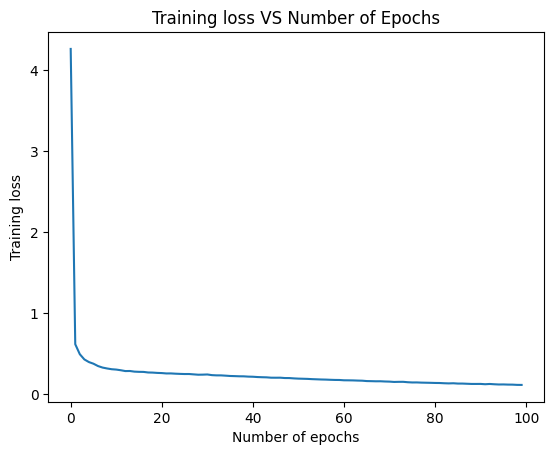

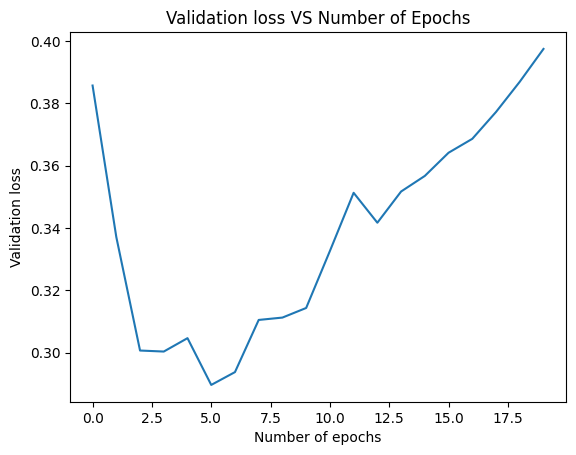

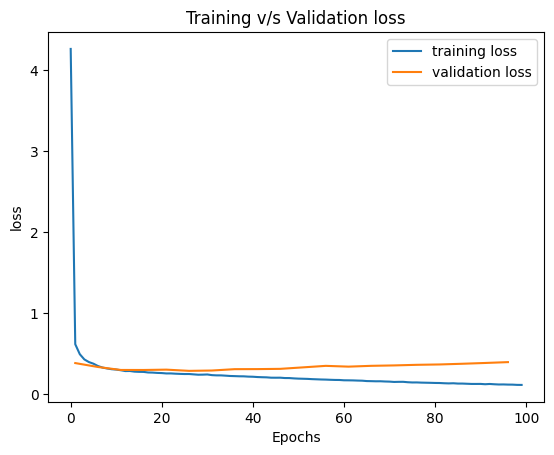

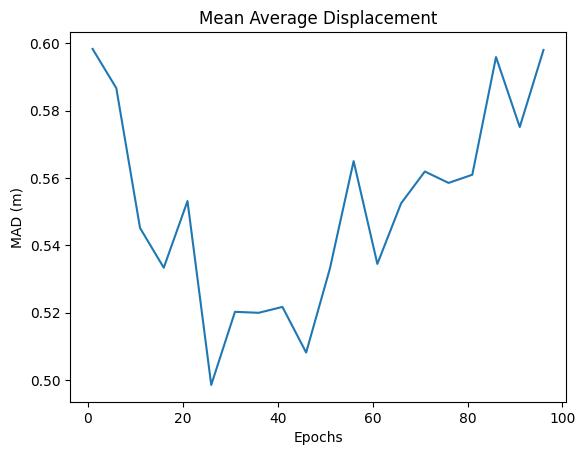

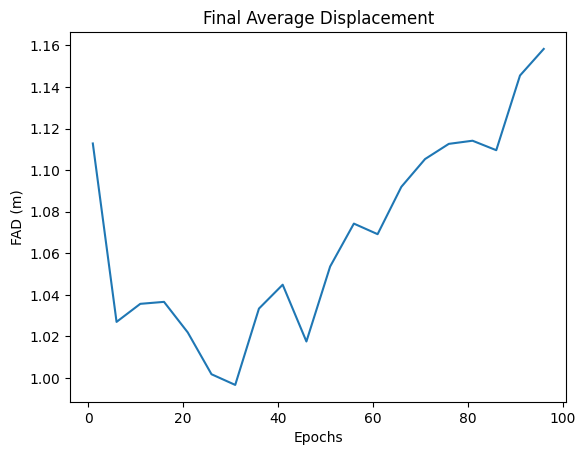

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
loaded_file = torch.load(os.path.join(
    save_location, 'LSTM_epoch100.pth'), map_location=torch.device(device))

# creating model and loading weights
# encoder_ip_size = 2
# decoder_ip_size = 3
# model_op_size = 3
# emb_size = 512
# num_heads = 8
# ff_hidden_size = 2048
# n = 6
# dropout = 0.1

# model_loaded = model.TFModel(encoder_ip_size, decoder_ip_size, model_op_size, emb_size,
#                              num_heads, ff_hidden_size, n, dropout=0.1)

model_loaded = model_LSTM.LSTM(input_size=2, input_seq_len=8,
                             hidden_size=128, num_layers=2, output_size=2, output_seq_len=12)


model_loaded = model_loaded.to(device)
model_loaded.load_state_dict(loaded_file['model_state_dict'])

# loading training metric variables
training_loss = loaded_file['training_loss']
validation_loss = loaded_file['validation_loss']
val_mad = loaded_file['val_mad']
val_fad = loaded_file['val_fad']
learning_rate = loaded_file['learning_rate']

# plotting training loss
plt.figure()
plt.plot(training_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")
plt.title("Training loss VS Number of Epochs")

# plotting validation loss
plt.figure()
plt.plot(validation_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Validation loss")
plt.title("Validation loss VS Number of Epochs")

# plotting training and validation loss together
plt.figure()
plt.plot(loaded_file['training_loss'], label="training loss")
plt.plot(np.arange(1, 100, 5),
            loaded_file['validation_loss'], label="validation loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Training v/s Validation loss")
plt.savefig("loss.png")

# plotting learning rate for model
# plt.figure()
# plt.plot(learning_rate)
# plt.xlabel("Number of epochs")
# plt.ylabel("learning_rate")
# plt.title("Learning_rate VS Number of Epochs")

# plotting MAD
plt.figure()
plt.plot(np.arange(1, 100, 5),
            loaded_file['val_mad'], label="validation MAD")
plt.xlabel("Epochs")
plt.ylabel("MAD (m)")
plt.title("Mean Average Displacement")
plt.savefig("mad.png")

# plotting FAD
plt.figure()
plt.plot(np.arange(1, 100, 5),
            loaded_file['val_fad'], label="validation FAD")
plt.xlabel("Epochs")
plt.ylabel("FAD (m)")
plt.title("Final Average Displacement")
plt.savefig("fad.png")

plt.show()

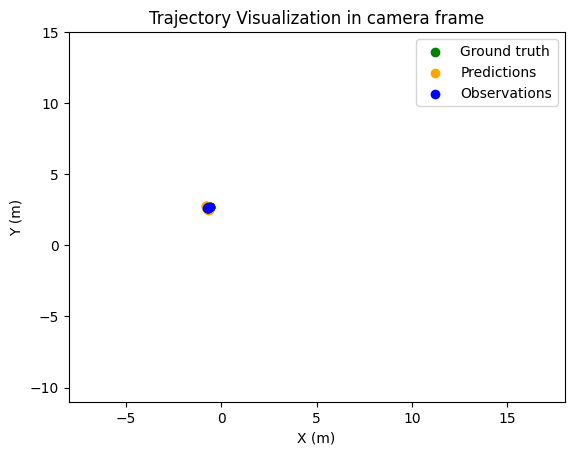

In [11]:
# Running the validation loop to generate prediction trajectories on validation data
validation_loss = []
val_mad = []
val_fad = []

with torch.no_grad():
    # EVALUATION MODE
    model_loaded.eval()

    # validation variables
    batch_val_loss = 0
    gt = []
    pr = []
    obs = []

    for id_b, data in enumerate(val_loader):
        # storing groung truth
        truth = data['trg'][:, :, 0:2]
        gt.append(data['trg'][:, :, 0:2])
        obs.append(data['src'][:, :, 0:2])
        # input to encoder input
        val_input = data['src'][:, :, 0:2]

        # prediction till horizon lenght
        model_output = model_loaded.forward(val_input)
        pr.append(model_output.view(val_input.size(0), 12, -1))

        # calculating loss using pairwise distance of all predictions
        val_loss = criterion(model_output.view(val_input.size(0), -1), truth.contiguous().view(val_input.size(0), -1))
        batch_val_loss += val_loss.item()

        validation_loss.append(batch_val_loss/len(val_loader))

    # calculating mad and fad evaluation metrics
    gt = np.concatenate(gt, 0)
    pr = np.concatenate(pr, 0)
    obs = np.concatenate(obs, 0)
    mad, fad, _ = dataloader.distance_metrics(gt, pr)
    val_mad.append(mad)
    val_fad.append(fad)

# plotting the predicted and ground truth trajectories
idx = np.random.randint(0, gt.shape[0])
plt.figure()
plt.scatter(gt[idx, :, 0], gt[idx, :, 1],
            color='green', label="Ground truth")
plt.scatter(pr[idx, :, 0], pr[idx, :, 1],
            color='orange', label="Predictions")
plt.scatter(obs[idx, :, 0], obs[idx, :, 1],
            color='b', label="Observations")
plt.legend()
plt.xlim(-8, 18)
plt.ylim(-11, 15)
plt.title("Trajectory Visualization in camera frame")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.savefig("traj_{}".format(idx))

plt.show()

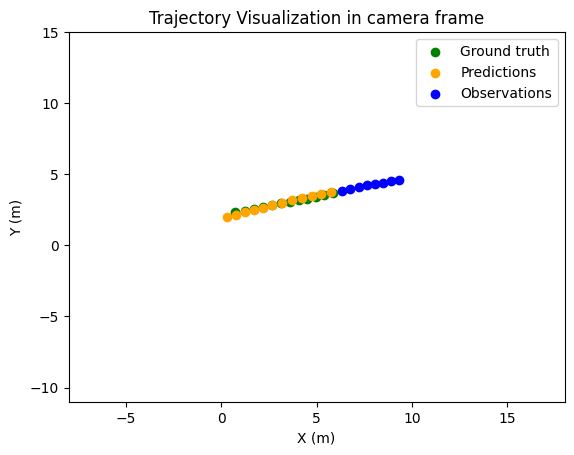

In [12]:
# plotting the predicted and ground truth trajectories
idx = np.random.randint(0, gt.shape[0])
plt.figure()
plt.scatter(gt[idx, :, 0], gt[idx, :, 1],
            color='green', label="Ground truth")
plt.scatter(pr[idx, :, 0], pr[idx, :, 1],
            color='orange', label="Predictions")
plt.scatter(obs[idx, :, 0], obs[idx, :, 1],
            color='b', label="Observations")
plt.legend()
plt.xlim(-8, 18)
plt.ylim(-11, 15)
plt.title("Trajectory Visualization in camera frame")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.savefig("traj_{}".format(idx))

plt.show()

## 6. Evaluation on test set